# Practical session: WORDLE with Bayes, a winning move

The topic of this session is to code an agent that plays WORDLE (and hopefully be succesful at it). For those who do not know this game, take a look at this [link](https://wordle.louan.me/)

The following code allows to play and visualize the game in interactive mode. It is mostly inspired from this github repository [https://github.com/Botafogo1894/Wordle]

You are given a file `5_lettres.txt` containing many 5 letters words from french. You are allowed in the rest of the practical sessions to use this full list to build your prior distributions.

In [204]:
import numpy as np
import pandas as pd
from IPython.display import display

def pick_random_word(tab):
    #Instantiate randomizer
    nb_words =  len(tab)
    idx = np.random.randint(nb_words)
    return tab[idx]

#Ask User Input
def ask_user_input(guru = None):
    while True:
        guru = input ("Entrez un mot de 5 lettres :")
        if type(guru) != str or len(guru) != 5:
            print('Invalid Entry')
            continue
        else:
            return guru.upper()

#Change Letter Colors
def color_positive(val):
    if val == val.upper() and len(val) == 1:
        color = 'green'
    elif len(val) == 2:
        color = 'orange'
    else:
        color = 'black'
    return 'color: %s' % color

def build_df(attempt, guess_arr):
    cols = ['L1', 'L2', 'L3', 'L4', 'L5']
    idx = ['ESSAI_' + str(attempt +1)]

    df = pd.DataFrame(guess_arr).T
    df.columns = cols
    df.index = idx

    return df

def mark_letters(guess_idx):
    final = []
    for item in guess_idx:
        if item[2] == 'YES':
            final.append(item[0])
        elif item[2] == 'EX':
            final.append(item[0] + ' ')
        else:
            final.append(item[0].lower())
    return final

#############################################
############  MAIN FUNCTION ################
#############################################
def play_wordle():
    file = open('5_lettres.txt')
    read_lines = file.readlines()
    tab_mots5 = []
    for mot in read_lines:
        mot = mot.rstrip()
        tab_mots5.append(mot)

    #Instantiate True word
    true_word = pick_random_word(tab_mots5)

    #Turn true word into array of individual letters and indexes
    true_arr = np.array(list(true_word.upper()))
    # print(true_arr)
    true_idx = [[item, idx, None] for idx, item in enumerate(true_arr)]
    # print(true_idx)

    attempt = 0
    guess_store = []

    while attempt < 6:
        #guess word
        guess_word = ask_user_input()
        guess_arr = np.array(list(guess_word))
        # print(guess_arr)
        guess_idx = [[item, idx, None] for idx, item in enumerate(guess_arr)]
        # print(guess_idx)

        matched = []
        existing = []
        matching = np.where(true_arr == guess_arr)[0]

        for item in matching:
            matched.append(guess_idx[item][0])
            guess_idx[item][2], true_idx[item][2] = 'YES', 'YES'

        rem_guess = [item for item in guess_idx if item[2] != 'YES']
        rem_true = [item for item in true_idx if item[2] != 'YES']
        # print(rem_guess, rem_true)

        for guess in rem_guess:
            for true in rem_true:
                if guess[0] == true[0]:
                    if list(true_arr).count(guess[0]) > (matched.count(guess[0]) + existing.count(guess[0])):
                        existing.append(guess[0])
                        guess[2], true[2] = 'EX', 'EX'
                    else:
                        continue

        #Apply logic to each value in DataFrame to Color letters
        def color_positive(val):
            if val == val.upper() and len(val) == 1:
                color = 'green'
            elif len(val) == 2:
                color = 'orange'
            else:
                color = 'grey'
            return 'color: %s' % color

        #Mark letters based on match, exist, or not exist
        final = mark_letters(guess_idx)

        #Turn current guess word into row in pandas DF
        guess_df = build_df(attempt, final)
        guess_store.append(guess_df)
        new_df = pd.concat(guess_store)

        #Use color_positive function to color letters
        s = new_df.style.map(color_positive)
        display(s)

        if guess_word.lower() == true_word:
            print('##############################################################')
            print(f'       Bingo ! Le mot correct était bien {true_word.upper()} ')
            print('##############################################################')
            break
        else:
            attempt += 1

            if attempt == 6:
                print(f'Désolé ! Le bon mot était {true_word.upper()}')
                break

play_wordle()

,L1,L2,L3,L4,L5
ESSAI_1,a,c,a,B,A


,L1,L2,L3,L4,L5
ESSAI_1,a,c,a,B,A
ESSAI_2,a,c,a,B,A


,L1,L2,L3,L4,L5
ESSAI_1,a,c,a,B,A
ESSAI_2,a,c,a,B,A
ESSAI_3,a,c,a,B,A


,L1,L2,L3,L4,L5
ESSAI_1,a,c,a,B,A
ESSAI_2,a,c,a,B,A
ESSAI_3,a,c,a,B,A
ESSAI_4,a,c,a,B,A


,L1,L2,L3,L4,L5
ESSAI_1,a,c,a,B,A
ESSAI_2,a,c,a,B,A
ESSAI_3,a,c,a,B,A
ESSAI_4,a,c,a,B,A
ESSAI_5,a,c,a,B,A


,L1,L2,L3,L4,L5
ESSAI_1,a,c,a,B,A
ESSAI_2,a,c,a,B,A
ESSAI_3,a,c,a,B,A
ESSAI_4,a,c,a,B,A
ESSAI_5,a,c,a,B,A
ESSAI_6,a,c,a,B,A


Désolé ! Le bon mot était HERBA


# Your turn: WORDLE agents that plays with Bayes rule !

Your goal is to develop an agent that will play the wordle game and wins hopefully most of the time. The basic idea is to maintain a probability information about the plausible letters that are missing along the different trials. You have a complete latitude to choose the way to express the prior probability information. Several heuristics are possible. First, you can establish empirical probabilities of apparition of letters (given or not their positions in the word), thanks to the list of words which is available for you. Then, as new evidences appear, you can use the Bayes rule to update your probability score. 

From this probability distribution, you can use the following function to sample from it:
```python
np.random.choice( )
```
(documentation [here](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html))

Your tasks are the following:
1. First, build a dumb agent that plays randomly
2. Second, build several agents that work with more and more advanced sampling strategy
3. Compare the performances of those different agents by making them play a random number of games. Their efficiency will be measured as a function of winning games and the number of moves they need to finish one puzzle
    

(**Bonus situation**: I have also included a file (more lengthy) with all the 6 letters words in french. Adapt the code to it and verify that you best agent is still the best)

## Agent Bayesien mots de 5

In [205]:
import numpy as np
import pandas as pd
from IPython.display import display

def load_words(file_path="5_lettres.txt"):
    with open(file_path, "r", encoding="utf-8") as file:
        return [line.strip().upper() for line in file.readlines()]

def evaluate_guess(guess, true_word):
    result = []
    for i, letter in enumerate(guess):
        if letter == true_word[i]:
            result.append("green")  
        elif letter in true_word:
            result.append("orange")  
        else:
            result.append("grey")  
    return result

def mark_letters(guess_idx):
    final = []
    for item in guess_idx:
        if item[2] == 'YES':
            final.append(item[0])
        elif item[2] == 'EX':
            final.append(item[0] + ' ')
        else:
            final.append(item[0].lower())
    return final

def build_df(attempt, guess_arr):
    cols = ['L1', 'L2', 'L3', 'L4', 'L5']
    idx = ['ESSAI_' + str(attempt + 1)]
    df = pd.DataFrame(guess_arr).T
    df.columns = cols
    df.index = idx
    return df

def color_positive(val):
    if val == val.upper() and len(val) == 1:
        color = 'green'
    elif len(val) == 2:
        color = 'orange'
    else:
        color = 'grey'
    return f'color: {color}'


def bayesian_agent(word_list, true_word, max_attempts=6):
    letter_probs = {letter: 1 / len("ABCDEFGHIJKLMNOPQRSTUVWXYZ") for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"}
    attempts = 0
    possible_words = word_list
    guess_store = []

    print(f"Mot correct (pour test uniquement) : {true_word}")

    while attempts < max_attempts:
        guess_word = max(possible_words, key=lambda word: sum(letter_probs[letter] for letter in word))
        feedback = evaluate_guess(guess_word, true_word)
        guess_arr = np.array(list(guess_word))
        guess_idx = [[item, idx, None] for idx, item in enumerate(guess_arr)]

        for i, color in enumerate(feedback):
            if color == "green":
                guess_idx[i][2] = 'YES'
            elif color == "orange":
                guess_idx[i][2] = 'EX'

        def word_matches(word, guess, feedback):
            for i, (letter, color) in enumerate(zip(guess, feedback)):
                if color == "green" and word[i] != letter:
                    return False
                if color == "orange" and (letter not in word or word[i] == letter):
                    return False
                if color == "grey" and letter in word:
                    return False
            return True

        possible_words = [word for word in possible_words if word_matches(word, guess_word, feedback)]

        final = mark_letters(guess_idx)
        guess_df = build_df(attempts, final)
        guess_store.append(guess_df)
        new_df = pd.concat(guess_store)
        s = new_df.style.map(color_positive)
        display(s)

        if guess_word == true_word:
            print("🎉 Bingo ! L'agent a trouvé le mot correct ! 🎉")
            return attempts + 1

        for letter, color in zip(guess_word, feedback):
            if color == "green":
                letter_probs[letter] += 0.2
            elif color == "orange":
                letter_probs[letter] += 0.1
            else:
                letter_probs[letter] -= 0.1
        total_prob = sum(max(p, 0) for p in letter_probs.values())
        letter_probs = {letter: max(p, 0) / total_prob for letter, p in letter_probs.items()}

        attempts += 1

    print(f"Dommage ! L'agent n'a pas trouvé le mot. Le mot correct était : {true_word}")
    return max_attempts


word_list = load_words("5_lettres.txt")
true_word = np.random.choice(word_list)  
bayesian_agent(word_list, true_word)


Mot correct (pour test uniquement) : OEILS


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,d,E,d,I,E


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,d,E,d,I,E
ESSAI_3,r,E,I,E,z


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,d,E,d,I,E
ESSAI_3,r,E,I,E,z
ESSAI_4,m,E,I,j,I


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,d,E,d,I,E
ESSAI_3,r,E,I,E,z
ESSAI_4,m,E,I,j,I
ESSAI_5,f,E,I,n,S


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,d,E,d,I,E
ESSAI_3,r,E,I,E,z
ESSAI_4,m,E,I,j,I
ESSAI_5,f,E,I,n,S
ESSAI_6,O,E,I,L,S


🎉 Bingo ! L'agent a trouvé le mot correct ! 🎉


6

# pour les mots a 6 caractères 

In [206]:
import numpy as np
import pandas as pd
from IPython.display import display

def load_words(file_path="6_lettres.txt"):
    with open(file_path, "r", encoding="utf-8") as file:
        return [line.strip().upper() for line in file.readlines()]

def evaluate_guess(guess, true_word):
    result = []
    for i, letter in enumerate(guess):
        if letter == true_word[i]:
            result.append("green")  
        elif letter in true_word:
            result.append("orange")  
        else:
            result.append("grey")  
    return result

def mark_letters(guess_idx):
    final = []
    for item in guess_idx:
        if item[2] == 'YES':
            final.append(item[0])
        elif item[2] == 'EX':
            final.append(item[0] + ' ')
        else:
            final.append(item[0].lower())
    return final

def build_df(attempt, guess_arr):
    cols = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6']
    idx = ['ESSAI_' + str(attempt + 1)]
    df = pd.DataFrame(guess_arr).T
    df.columns = cols
    df.index = idx
    return df

def color_positive(val):
    if val == val.upper() and len(val) == 1:
        color = 'green'
    elif len(val) == 2:
        color = 'orange'
    else:
        color = 'grey'
    return f'color: {color}'

# Agent Bayesien
def bayesian_agent(word_list, true_word, max_attempts=6):
    letter_probs = {letter: 1 / len("ABCDEFGHIJKLMNOPQRSTUVWXYZ") for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"}
    attempts = 0
    possible_words = word_list
    guess_store = []

    print(f"Mot correct (pour test uniquement) : {true_word}")

    while attempts < max_attempts:
        guess_word = max(possible_words, key=lambda word: sum(letter_probs[letter] for letter in word))
        feedback = evaluate_guess(guess_word, true_word)
        guess_arr = np.array(list(guess_word))
        guess_idx = [[item, idx, None] for idx, item in enumerate(guess_arr)]

        for i, color in enumerate(feedback):
            if color == "green":
                guess_idx[i][2] = 'YES'
            elif color == "orange":
                guess_idx[i][2] = 'EX'

        def word_matches(word, guess, feedback):
            for i, (letter, color) in enumerate(zip(guess, feedback)):
                if color == "green" and word[i] != letter:
                    return False
                if color == "orange" and (letter not in word or word[i] == letter):
                    return False
                if color == "grey" and letter in word:
                    return False
            return True

        possible_words = [word for word in possible_words if word_matches(word, guess_word, feedback)]

        final = mark_letters(guess_idx)
        guess_df = build_df(attempts, final)
        guess_store.append(guess_df)
        new_df = pd.concat(guess_store)
        s = new_df.style.map(color_positive)
        display(s)

        if guess_word == true_word:
            print("🎉 Bingo ! L'agent a trouvé le mot correct ! 🎉")
            return attempts + 1

        for letter, color in zip(guess_word, feedback):
            if color == "green":
                letter_probs[letter] += 0.2
            elif color == "orange":
                letter_probs[letter] += 0.1
            else:
                letter_probs[letter] -= 0.05
        total_prob = sum(max(p, 0) for p in letter_probs.values())
        letter_probs = {letter: max(p, 0) / total_prob for letter, p in letter_probs.items()}

        attempts += 1

    print(f"Dommage ! L'agent n'a pas trouvé le mot. Le mot correct était : {true_word}")
    return max_attempts


word_list = load_words("6_lettres.txt")
true_word = np.random.choice(word_list)  
bayesian_agent(word_list, true_word)


Mot correct (pour test uniquement) : FREMIR


,L1,L2,L3,L4,L5,L6
ESSAI_1,a,b,a,c,a,s


,L1,L2,L3,L4,L5,L6
ESSAI_1,a,b,a,c,a,s
ESSAI_2,d,E,d,I,E,E


,L1,L2,L3,L4,L5,L6
ESSAI_1,a,b,a,c,a,s
ESSAI_2,d,E,d,I,E,E
ESSAI_3,E,l,E,g,I,R


,L1,L2,L3,L4,L5,L6
ESSAI_1,a,b,a,c,a,s
ESSAI_2,d,E,d,I,E,E
ESSAI_3,E,l,E,g,I,R
ESSAI_4,F,R,E,M,I,R


🎉 Bingo ! L'agent a trouvé le mot correct ! 🎉


4

## Agent dumb


In [208]:
import numpy as np
import pandas as pd
from IPython.display import display

def load_words(file_path="5_lettres.txt"):
    with open(file_path, "r", encoding="utf-8") as file:
        return [line.strip().upper() for line in file.readlines()]

def evaluate_guess(guess, true_word):
    result = []
    for i, letter in enumerate(guess):
        if letter == true_word[i]:
            result.append("green")  
        elif letter in true_word:
            result.append("orange")  
        else:
            result.append("grey")  
    return result

def mark_letters(guess_idx):
    final = []
    for item in guess_idx:
        if item[2] == 'YES':
            final.append(item[0])
        elif item[2] == 'EX':
            final.append(item[0] + ' ')
        else:
            final.append(item[0].lower())
    return final

def build_df(attempt, guess_arr):
    cols = ['L1', 'L2', 'L3', 'L4', 'L5']
    idx = ['ESSAI_' + str(attempt + 1)]
    df = pd.DataFrame(guess_arr).T
    df.columns = cols
    df.index = idx
    return df

def color_positive(val):
    if val == val.upper() and len(val) == 1:
        color = 'green'
    elif len(val) == 2:
        color = 'orange'
    else:
        color = 'grey'
    return f'color: {color}'


def dumb__agent(word_list, true_word, max_attempts=6):
    attempts = 0
    possible_words = word_list  
    guess_store = []

    print(f"Mot correct (pour test uniquement) : {true_word}")

    while attempts < max_attempts:
        guess_word = np.random.choice(possible_words)
        feedback = evaluate_guess(guess_word, true_word)
        guess_arr = np.array(list(guess_word))
        guess_idx = [[item, idx, None] for idx, item in enumerate(guess_arr)]

        for i, color in enumerate(feedback):
            if color == "green":
                guess_idx[i][2] = 'YES'
            elif color == "orange":
                guess_idx[i][2] = 'EX'

        final = mark_letters(guess_idx)
        guess_df = build_df(attempts, final)
        guess_store.append(guess_df)
        new_df = pd.concat(guess_store)
        s = new_df.style.map(color_positive)
        display(s)

        if guess_word == true_word:
            print("🎉 Bingo ! L'agent aléatoire a trouvé le mot correct ! 🎉")
            return attempts + 1

        attempts += 1

    print(f"Dommage ! L'agent aléatoire n'a pas trouvé le mot. Le mot correct était : {true_word}")
    return max_attempts

word_list = load_words("5_lettres.txt")
true_word = np.random.choice(word_list) 
dumb__agent(word_list, true_word)


Mot correct (pour test uniquement) : DRIVA


,L1,L2,L3,L4,L5
ESSAI_1,p,A,n,t,e


,L1,L2,L3,L4,L5
ESSAI_1,p,A,n,t,e
ESSAI_2,s,e,A,u,x


,L1,L2,L3,L4,L5
ESSAI_1,p,A,n,t,e
ESSAI_2,s,e,A,u,x
ESSAI_3,R,I,m,e,z


,L1,L2,L3,L4,L5
ESSAI_1,p,A,n,t,e
ESSAI_2,s,e,A,u,x
ESSAI_3,R,I,m,e,z
ESSAI_4,o,k,A,p,I


,L1,L2,L3,L4,L5
ESSAI_1,p,A,n,t,e
ESSAI_2,s,e,A,u,x
ESSAI_3,R,I,m,e,z
ESSAI_4,o,k,A,p,I
ESSAI_5,n,o,t,R,e


,L1,L2,L3,L4,L5
ESSAI_1,p,A,n,t,e
ESSAI_2,s,e,A,u,x
ESSAI_3,R,I,m,e,z
ESSAI_4,o,k,A,p,I
ESSAI_5,n,o,t,R,e
ESSAI_6,l,o,t,I,s


Dommage ! L'agent aléatoire n'a pas trouvé le mot. Le mot correct était : DRIVA


6

## Agent probabiliste smarty

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display

def load_words(file_path="5_lettres.txt"):
    with open(file_path, "r", encoding="utf-8") as file:
        return [line.strip().upper() for line in file.readlines()]

def evaluate_guess(guess, true_word):
    result = []
    for i, letter in enumerate(guess):
        if letter == true_word[i]:
            result.append("green")  
        elif letter in true_word:
            result.append("orange")  
        else:
            result.append("grey")  
    return result

def mark_letters(guess_idx):
    final = []
    for item in guess_idx:
        if item[2] == 'YES':
            final.append(item[0])
        elif item[2] == 'EX':
            final.append(item[0] + ' ')
        else:
            final.append(item[0].lower())
    return final

def build_df(attempt, guess_arr):
    cols = ['L1', 'L2', 'L3', 'L4', 'L5']
    idx = ['ESSAI_' + str(attempt + 1)]
    df = pd.DataFrame(guess_arr).T
    df.columns = cols
    df.index = idx
    return df

def color_positive(val):
    if val == val.upper() and len(val) == 1:
        color = 'green'
    elif len(val) == 2:
        color = 'orange'
    else:
        color = 'grey'
    return f'color: {color}'

def probabilistic_agent(word_list, true_word, max_attempts=6):
    attempts = 0
    possible_words = word_list  
    guess_store = []

    print(f"Mot correct (pour test uniquement) : {true_word}")

    letter_freq = {letter: 0 for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"}
    for word in word_list:
        for letter in set(word): 
            letter_freq[letter] += 1

    while attempts < max_attempts:
       
        guess_word = max(possible_words, key=lambda word: sum(letter_freq[letter] for letter in set(word)))
        feedback = evaluate_guess(guess_word, true_word)
        guess_arr = np.array(list(guess_word))
        guess_idx = [[item, idx, None] for idx, item in enumerate(guess_arr)]

        for i, color in enumerate(feedback):
            if color == "green":
                guess_idx[i][2] = 'YES'
            elif color == "orange":
                guess_idx[i][2] = 'EX'

        final = mark_letters(guess_idx)
        guess_df = build_df(attempts, final)
        guess_store.append(guess_df)
        new_df = pd.concat(guess_store)
        s = new_df.style.map(color_positive)
        display(s)

  
        if guess_word == true_word:
            print("🎉 Bingo ! L'agent probabiliste a trouvé le mot correct ! 🎉")
            return attempts + 1

     
        def word_matches(word, guess, feedback):
            for i, (letter, color) in enumerate(zip(guess, feedback)):
                if color == "green" and word[i] != letter:
                    return False
                if color == "orange" and (letter not in word or word[i] == letter):
                    return False
                if color == "grey" and letter in word:
                    return False
            return True

        possible_words = [word for word in possible_words if word_matches(word, guess_word, feedback)]

       
        letter_freq = {letter: 0 for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"}
        for word in possible_words:
            for letter in set(word):
                letter_freq[letter] += 1

        attempts += 1

    print(f"Dommage ! L'agent probabiliste n'a pas trouvé le mot. Le mot correct était : {true_word}")
    return max_attempts


word_list = load_words("5_lettres.txt")
true_word = np.random.choice(word_list)  
probabilistic_agent(word_list, true_word)


Mot correct (pour test uniquement) : LAIES


,L1,L2,L3,L4,L5
ESSAI_1,A,I,r,E,S


,L1,L2,L3,L4,L5
ESSAI_1,A,I,r,E,S
ESSAI_2,b,A,I,E,S


,L1,L2,L3,L4,L5
ESSAI_1,A,I,r,E,S
ESSAI_2,b,A,I,E,S
ESSAI_3,g,A,I,E,S


,L1,L2,L3,L4,L5
ESSAI_1,A,I,r,E,S
ESSAI_2,b,A,I,E,S
ESSAI_3,g,A,I,E,S
ESSAI_4,h,A,I,E,S


,L1,L2,L3,L4,L5
ESSAI_1,A,I,r,E,S
ESSAI_2,b,A,I,E,S
ESSAI_3,g,A,I,E,S
ESSAI_4,h,A,I,E,S
ESSAI_5,L,A,I,E,S


🎉 Bingo ! L'agent probabiliste a trouvé le mot correct ! 🎉


5

## calculs eand plot 

Mot correct (pour test uniquement) : TAROS


,L1,L2,L3,L4,L5
ESSAI_1,A,i,R,e,S


,L1,L2,L3,L4,L5
ESSAI_1,A,i,R,e,S
ESSAI_2,d,O,R,A,S


,L1,L2,L3,L4,L5
ESSAI_1,A,i,R,e,S
ESSAI_2,d,O,R,A,S
ESSAI_3,f,A,R,O,S


,L1,L2,L3,L4,L5
ESSAI_1,A,i,R,e,S
ESSAI_2,d,O,R,A,S
ESSAI_3,f,A,R,O,S
ESSAI_4,p,A,R,O,S


,L1,L2,L3,L4,L5
ESSAI_1,A,i,R,e,S
ESSAI_2,d,O,R,A,S
ESSAI_3,f,A,R,O,S
ESSAI_4,p,A,R,O,S
ESSAI_5,T,A,R,O,S


🎉 Bingo ! L'agent probabiliste a trouvé le mot correct ! 🎉
Mot correct (pour test uniquement) : TAGUE


,L1,L2,L3,L4,L5
ESSAI_1,A,i,r,E,s


,L1,L2,L3,L4,L5
ESSAI_1,A,i,r,E,s
ESSAI_2,c,A,l,T,E


,L1,L2,L3,L4,L5
ESSAI_1,A,i,r,E,s
ESSAI_2,c,A,l,T,E
ESSAI_3,T,A,G,U,E


🎉 Bingo ! L'agent probabiliste a trouvé le mot correct ! 🎉
Mot correct (pour test uniquement) : GERAS


,L1,L2,L3,L4,L5
ESSAI_1,A,i,R,E,S


,L1,L2,L3,L4,L5
ESSAI_1,A,i,R,E,S
ESSAI_2,E,y,R,A,S


,L1,L2,L3,L4,L5
ESSAI_1,A,i,R,E,S
ESSAI_2,E,y,R,A,S
ESSAI_3,f,E,R,A,S


,L1,L2,L3,L4,L5
ESSAI_1,A,i,R,E,S
ESSAI_2,E,y,R,A,S
ESSAI_3,f,E,R,A,S
ESSAI_4,G,E,R,A,S


🎉 Bingo ! L'agent probabiliste a trouvé le mot correct ! 🎉
Mot correct (pour test uniquement) : BISSA


,L1,L2,L3,L4,L5
ESSAI_1,A,I,r,e,S


,L1,L2,L3,L4,L5
ESSAI_1,A,I,r,e,S
ESSAI_2,l,I,S,t,A


,L1,L2,L3,L4,L5
ESSAI_1,A,I,r,e,S
ESSAI_2,l,I,S,t,A
ESSAI_3,B,I,S,S,A


🎉 Bingo ! L'agent probabiliste a trouvé le mot correct ! 🎉
Mot correct (pour test uniquement) : LOASE


,L1,L2,L3,L4,L5
ESSAI_1,A,i,r,E,S


,L1,L2,L3,L4,L5
ESSAI_1,A,i,r,E,S
ESSAI_2,L,E,S,A,t


,L1,L2,L3,L4,L5
ESSAI_1,A,i,r,E,S
ESSAI_2,L,E,S,A,t
ESSAI_3,L,A,p,S,E


,L1,L2,L3,L4,L5
ESSAI_1,A,i,r,E,S
ESSAI_2,L,E,S,A,t
ESSAI_3,L,A,p,S,E
ESSAI_4,L,O,A,S,E


🎉 Bingo ! L'agent probabiliste a trouvé le mot correct ! 🎉
Mot correct (pour test uniquement) : VASEZ


,L1,L2,L3,L4,L5
ESSAI_1,A,i,r,E,S


,L1,L2,L3,L4,L5
ESSAI_1,A,i,r,E,S
ESSAI_2,S,A,l,E,Z


,L1,L2,L3,L4,L5
ESSAI_1,A,i,r,E,S
ESSAI_2,S,A,l,E,Z
ESSAI_3,b,A,S,E,Z


,L1,L2,L3,L4,L5
ESSAI_1,A,i,r,E,S
ESSAI_2,S,A,l,E,Z
ESSAI_3,b,A,S,E,Z
ESSAI_4,c,A,S,E,Z


,L1,L2,L3,L4,L5
ESSAI_1,A,i,r,E,S
ESSAI_2,S,A,l,E,Z
ESSAI_3,b,A,S,E,Z
ESSAI_4,c,A,S,E,Z
ESSAI_5,j,A,S,E,Z


,L1,L2,L3,L4,L5
ESSAI_1,A,i,r,E,S
ESSAI_2,S,A,l,E,Z
ESSAI_3,b,A,S,E,Z
ESSAI_4,c,A,S,E,Z
ESSAI_5,j,A,S,E,Z
ESSAI_6,V,A,S,E,Z


🎉 Bingo ! L'agent probabiliste a trouvé le mot correct ! 🎉
Mot correct (pour test uniquement) : BAYER


,L1,L2,L3,L4,L5
ESSAI_1,A,i,R,E,s


,L1,L2,L3,L4,L5
ESSAI_1,A,i,R,E,s
ESSAI_2,p,A,t,E,R


,L1,L2,L3,L4,L5
ESSAI_1,A,i,R,E,s
ESSAI_2,p,A,t,E,R
ESSAI_3,c,A,l,E,R


,L1,L2,L3,L4,L5
ESSAI_1,A,i,R,E,s
ESSAI_2,p,A,t,E,R
ESSAI_3,c,A,l,E,R
ESSAI_4,g,A,v,E,R


,L1,L2,L3,L4,L5
ESSAI_1,A,i,R,E,s
ESSAI_2,p,A,t,E,R
ESSAI_3,c,A,l,E,R
ESSAI_4,g,A,v,E,R
ESSAI_5,d,A,m,E,R


,L1,L2,L3,L4,L5
ESSAI_1,A,i,R,E,s
ESSAI_2,p,A,t,E,R
ESSAI_3,c,A,l,E,R
ESSAI_4,g,A,v,E,R
ESSAI_5,d,A,m,E,R
ESSAI_6,B,A,Y,E,R


🎉 Bingo ! L'agent probabiliste a trouvé le mot correct ! 🎉
Mot correct (pour test uniquement) : AXERA


,L1,L2,L3,L4,L5
ESSAI_1,A,i,R,E,s


,L1,L2,L3,L4,L5
ESSAI_1,A,i,R,E,s
ESSAI_2,A,c,o,R,E


,L1,L2,L3,L4,L5
ESSAI_1,A,i,R,E,s
ESSAI_2,A,c,o,R,E
ESSAI_3,A,v,E,R,A


,L1,L2,L3,L4,L5
ESSAI_1,A,i,R,E,s
ESSAI_2,A,c,o,R,E
ESSAI_3,A,v,E,R,A
ESSAI_4,A,X,E,R,A


🎉 Bingo ! L'agent probabiliste a trouvé le mot correct ! 🎉
Mot correct (pour test uniquement) : CANER


,L1,L2,L3,L4,L5
ESSAI_1,A,i,R,E,s


,L1,L2,L3,L4,L5
ESSAI_1,A,i,R,E,s
ESSAI_2,p,A,t,E,R


,L1,L2,L3,L4,L5
ESSAI_1,A,i,R,E,s
ESSAI_2,p,A,t,E,R
ESSAI_3,C,A,l,E,R


,L1,L2,L3,L4,L5
ESSAI_1,A,i,R,E,s
ESSAI_2,p,A,t,E,R
ESSAI_3,C,A,l,E,R
ESSAI_4,C,A,m,E,R


,L1,L2,L3,L4,L5
ESSAI_1,A,i,R,E,s
ESSAI_2,p,A,t,E,R
ESSAI_3,C,A,l,E,R
ESSAI_4,C,A,m,E,R
ESSAI_5,C,A,N,E,R


🎉 Bingo ! L'agent probabiliste a trouvé le mot correct ! 🎉
Mot correct (pour test uniquement) : POUFS


,L1,L2,L3,L4,L5
ESSAI_1,a,i,r,e,S


,L1,L2,L3,L4,L5
ESSAI_1,a,i,r,e,S
ESSAI_2,l,O,t,U,S


,L1,L2,L3,L4,L5
ESSAI_1,a,i,r,e,S
ESSAI_2,l,O,t,U,S
ESSAI_3,d,O,U,m,S


,L1,L2,L3,L4,L5
ESSAI_1,a,i,r,e,S
ESSAI_2,l,O,t,U,S
ESSAI_3,d,O,U,m,S
ESSAI_4,c,O,U,P,S


,L1,L2,L3,L4,L5
ESSAI_1,a,i,r,e,S
ESSAI_2,l,O,t,U,S
ESSAI_3,d,O,U,m,S
ESSAI_4,c,O,U,P,S
ESSAI_5,P,O,U,F,S


🎉 Bingo ! L'agent probabiliste a trouvé le mot correct ! 🎉
Mot correct (pour test uniquement) : VOLTS


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,d,e,d,i,e


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,d,e,d,i,e
ESSAI_3,f,L,O,p,S


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,d,e,d,i,e
ESSAI_3,f,L,O,p,S
ESSAI_4,S,O,L,O,S


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,d,e,d,i,e
ESSAI_3,f,L,O,p,S
ESSAI_4,S,O,L,O,S
ESSAI_5,r,O,L,L,S


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,d,e,d,i,e
ESSAI_3,f,L,O,p,S
ESSAI_4,S,O,L,O,S
ESSAI_5,r,O,L,L,S
ESSAI_6,m,O,L,y,S


Dommage ! L'agent n'a pas trouvé le mot. Le mot correct était : VOLTS
Mot correct (pour test uniquement) : DOPES


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,D,E,D,i,E


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,D,E,D,i,E
ESSAI_3,D,O,g,E,S


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,D,E,D,i,E
ESSAI_3,D,O,g,E,S
ESSAI_4,D,O,S,E,S


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,D,E,D,i,E
ESSAI_3,D,O,g,E,S
ESSAI_4,D,O,S,E,S
ESSAI_5,D,O,l,E,S


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,D,E,D,i,E
ESSAI_3,D,O,g,E,S
ESSAI_4,D,O,S,E,S
ESSAI_5,D,O,l,E,S
ESSAI_6,D,O,m,E,S


Dommage ! L'agent n'a pas trouvé le mot. Le mot correct était : DOPES
Mot correct (pour test uniquement) : HONTE


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,d,E,d,i,E


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,d,E,d,i,E
ESSAI_3,E,l,E,v,E


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,d,E,d,i,E
ESSAI_3,E,l,E,v,E
ESSAI_4,f,O,r,E,E


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,d,E,d,i,E
ESSAI_3,E,l,E,v,E
ESSAI_4,f,O,r,E,E
ESSAI_5,z,O,O,m,E


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,d,E,d,i,E
ESSAI_3,E,l,E,v,E
ESSAI_4,f,O,r,E,E
ESSAI_5,z,O,O,m,E
ESSAI_6,g,O,s,s,E


Dommage ! L'agent n'a pas trouvé le mot. Le mot correct était : HONTE
Mot correct (pour test uniquement) : DORIS


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,D,e,D,I,e


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,D,e,D,I,e
ESSAI_3,D,I,g,I,t


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,D,e,D,I,e
ESSAI_3,D,I,g,I,t
ESSAI_4,D,O,R,I,n


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,D,e,D,I,e
ESSAI_3,D,I,g,I,t
ESSAI_4,D,O,R,I,n
ESSAI_5,D,O,R,I,S


🎉 Bingo ! L'agent a trouvé le mot correct ! 🎉
Mot correct (pour test uniquement) : MATES


,L1,L2,L3,L4,L5
ESSAI_1,A,b,A,c,A


,L1,L2,L3,L4,L5
ESSAI_1,A,b,A,c,A
ESSAI_2,d,A,d,A,S


,L1,L2,L3,L4,L5
ESSAI_1,A,b,A,c,A
ESSAI_2,d,A,d,A,S
ESSAI_3,g,A,u,S,S


,L1,L2,L3,L4,L5
ESSAI_1,A,b,A,c,A
ESSAI_2,d,A,d,A,S
ESSAI_3,g,A,u,S,S
ESSAI_4,h,A,S,E,S


,L1,L2,L3,L4,L5
ESSAI_1,A,b,A,c,A
ESSAI_2,d,A,d,A,S
ESSAI_3,g,A,u,S,S
ESSAI_4,h,A,S,E,S
ESSAI_5,S,A,i,E,S


,L1,L2,L3,L4,L5
ESSAI_1,A,b,A,c,A
ESSAI_2,d,A,d,A,S
ESSAI_3,g,A,u,S,S
ESSAI_4,h,A,S,E,S
ESSAI_5,S,A,i,E,S
ESSAI_6,f,A,M,E,S


Dommage ! L'agent n'a pas trouvé le mot. Le mot correct était : MATES
Mot correct (pour test uniquement) : BARDE


,L1,L2,L3,L4,L5
ESSAI_1,A,B,A,c,A


,L1,L2,L3,L4,L5
ESSAI_1,A,B,A,c,A
ESSAI_2,B,A,B,A,s


,L1,L2,L3,L4,L5
ESSAI_1,A,B,A,c,A
ESSAI_2,B,A,B,A,s
ESSAI_3,B,A,R,B,E


,L1,L2,L3,L4,L5
ESSAI_1,A,B,A,c,A
ESSAI_2,B,A,B,A,s
ESSAI_3,B,A,R,B,E
ESSAI_4,B,A,R,R,E


,L1,L2,L3,L4,L5
ESSAI_1,A,B,A,c,A
ESSAI_2,B,A,B,A,s
ESSAI_3,B,A,R,B,E
ESSAI_4,B,A,R,R,E
ESSAI_5,B,A,R,D,E


🎉 Bingo ! L'agent a trouvé le mot correct ! 🎉
Mot correct (pour test uniquement) : QUANT


,L1,L2,L3,L4,L5
ESSAI_1,A,b,A,c,A


,L1,L2,L3,L4,L5
ESSAI_1,A,b,A,c,A
ESSAI_2,g,r,A,A,l


,L1,L2,L3,L4,L5
ESSAI_1,A,b,A,c,A
ESSAI_2,g,r,A,A,l
ESSAI_3,d,i,A,m,s


,L1,L2,L3,L4,L5
ESSAI_1,A,b,A,c,A
ESSAI_2,g,r,A,A,l
ESSAI_3,d,i,A,m,s
ESSAI_4,e,p,A,T,e


,L1,L2,L3,L4,L5
ESSAI_1,A,b,A,c,A
ESSAI_2,g,r,A,A,l
ESSAI_3,d,i,A,m,s
ESSAI_4,e,p,A,T,e
ESSAI_5,o,T,A,N,T


,L1,L2,L3,L4,L5
ESSAI_1,A,b,A,c,A
ESSAI_2,g,r,A,A,l
ESSAI_3,d,i,A,m,s
ESSAI_4,e,p,A,T,e
ESSAI_5,o,T,A,N,T
ESSAI_6,T,U,A,N,T


Dommage ! L'agent n'a pas trouvé le mot. Le mot correct était : QUANT
Mot correct (pour test uniquement) : SODES


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,D,E,D,i,E


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,D,E,D,i,E
ESSAI_3,E,n,D,O,S


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,D,E,D,i,E
ESSAI_3,E,n,D,O,S
ESSAI_4,S,O,D,E,S


🎉 Bingo ! L'agent a trouvé le mot correct ! 🎉
Mot correct (pour test uniquement) : REVIF


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,d,E,d,I,E


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,d,E,d,I,E
ESSAI_3,F,E,l,I,n


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,d,E,d,I,E
ESSAI_3,F,E,l,I,n
ESSAI_4,k,E,F,I,R


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,d,E,d,I,E
ESSAI_3,F,E,l,I,n
ESSAI_4,k,E,F,I,R
ESSAI_5,p,E,R,I,F


,L1,L2,L3,L4,L5
ESSAI_1,a,b,a,c,a
ESSAI_2,d,E,d,I,E
ESSAI_3,F,E,l,I,n
ESSAI_4,k,E,F,I,R
ESSAI_5,p,E,R,I,F
ESSAI_6,R,E,t,I,F


Dommage ! L'agent n'a pas trouvé le mot. Le mot correct était : REVIF
Mot correct (pour test uniquement) : OSCAR


,L1,L2,L3,L4,L5
ESSAI_1,A,b,A,C,A


,L1,L2,L3,L4,L5
ESSAI_1,A,b,A,C,A
ESSAI_2,C,A,C,A,O


,L1,L2,L3,L4,L5
ESSAI_1,A,b,A,C,A
ESSAI_2,C,A,C,A,O
ESSAI_3,f,O,C,A,l


,L1,L2,L3,L4,L5
ESSAI_1,A,b,A,C,A
ESSAI_2,C,A,C,A,O
ESSAI_3,f,O,C,A,l
ESSAI_4,O,S,C,A,R


🎉 Bingo ! L'agent a trouvé le mot correct ! 🎉
Agent: Dumb Agent
Wins: 0, Losses: 10
Average Attempts (Wins): N/A
Agent: Probabilistic Agent
Wins: 10, Losses: 0
Average Attempts (Wins): 4.5
Agent: Bayesian Agent
Wins: 10, Losses: 0
Average Attempts (Wins): 5.4


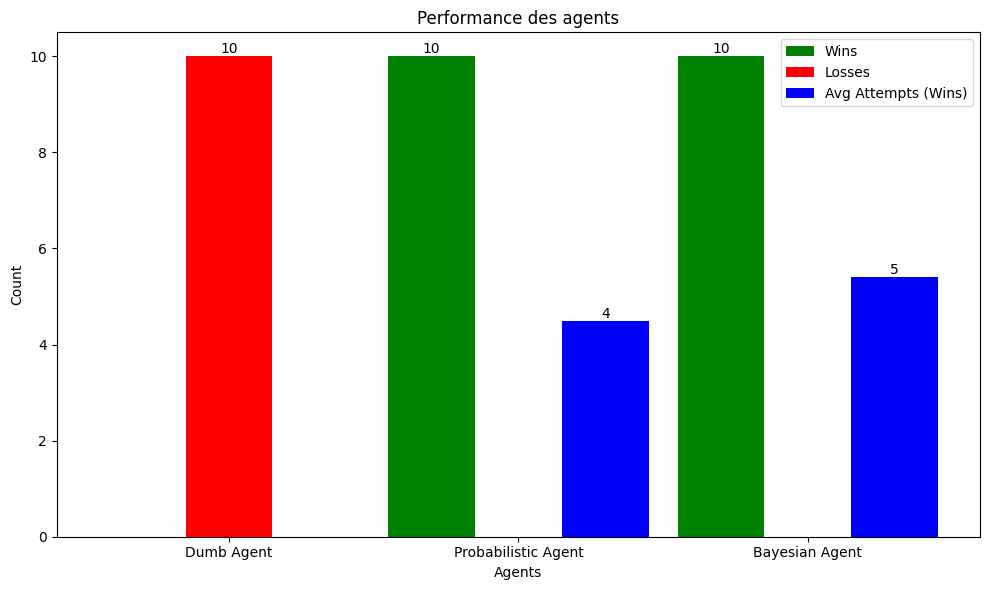

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

def test_agent(agent_function, word_list, num_tests=10, max_attempts=6):
    results = []
    for _ in range(num_tests):
        true_word = np.random.choice(word_list)
        attempts = agent_function(word_list, true_word, max_attempts)
        if attempts <= max_attempts:
            results.append(("WIN", attempts))
        else:
            results.append(("LOSE", None))
    return results

def display_results(agent_name, results):
    wins = sum(1 for result in results if result[0] == "WIN")
    losses = len(results) - wins
    avg_attempts = sum(result[1] for result in results if result[1] is not None) / wins if wins > 0 else None
    print(f"Agent: {agent_name}")
    print(f"Wins: {wins}, Losses: {losses}")
    print(f"Average Attempts (Wins): {avg_attempts if avg_attempts else 'N/A'}")
    return {"Agent": agent_name, "Wins": wins, "Losses": losses, "AvgAttempts": avg_attempts}

def plot_results(results_list):

    agents = [res["Agent"] for res in results_list]
    wins = [res["Wins"] for res in results_list]
    losses = [res["Losses"] for res in results_list]
    avg_attempts = [res["AvgAttempts"] if res["AvgAttempts"] else 0 for res in results_list]

   
    x = np.arange(len(agents)) 
    width = 0.3  

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width, wins, width, label="Wins", color="green")
    bars2 = ax.bar(x, losses, width, label="Losses", color="red")
    bars3 = ax.bar(x + width, avg_attempts, width, label="Avg Attempts (Wins)", color="blue")

    
    ax.set_xlabel("Agents")
    ax.set_ylabel("Count")
    ax.set_title("Performance des agents")
    ax.set_xticks(x)
    ax.set_xticklabels(agents)
    ax.legend()

   
    for bar_group in (bars1, bars2, bars3):
        for bar in bar_group:
            height = bar.get_height()
            if height > 0:  
                ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

word_list = load_words("5_lettres.txt")

results_dumb = test_agent(dumb_agent, word_list)
results_probabilistic = test_agent(probabilistic_agent, word_list)
results_bayesian = test_agent(bayesian_agent, word_list)


results_summary = [
    display_results("Dumb Agent", results_dumb),
    display_results("Probabilistic Agent", results_probabilistic),
    display_results("Bayesian Agent", results_bayesian)
]


plot_results(results_summary)
